
Muturretik muturrerako solasaldi sistema
===================================

Notebook honetan (https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html) oinarrituta, muturretik muturrerako solasaldi sistema bat entrenatzeko kodea topatuko duzu. 

Muturretik muturrerako sistema hau Neural machine translation by jointly learning to align and translate (Bahdanau, D., Cho, K., & Bengio, Y. (2014)) artikuluan proposatutako sisteman oinarritzen da eta solsaldia itzulpen automatikoko ataza bat bezala proposatzen du. 

Oharra: Notebook hau hurrengo kodean oinarritzen da: https://github.com/spro/practical-pytorch


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd "/content/drive/MyDrive/Ingeniaritza Informatikoa/4. Maila/2. Lauhilekoa/HP/Lana/dialbot"

/content/drive/MyDrive/Ingeniaritza Informatikoa/4. Maila/2. Lauhilekoa/HP/Lana/dialbot


https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb

https://github.com/bentrevett/pytorch-seq2seq/blob/master/4%20-%20Packed%20Padded%20Sequences%2C%20Masking%2C%20Inference%20and%20BLEU.ipynb

https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

https://colab.research.google.com/github/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb#scrollTo=YzSfu75AtQ97

## Preprocess Text

In [3]:
def get_text(filename, lines=None):
    with open(filename) as f:
        if lines is None:
            text = f.readlines()
        else:
            text = f.readlines()[:lines+1]
    return text

In [4]:
def clean_text(lines):
    clean = []
    for line in lines:
        clean.append(clean_line(line))
    return clean

In [5]:
def clean_line(t):
    t = t.replace('-', '')
    t = t.replace('\"', '')
    t = t.replace('\'', '')
    t = t.lower()
    return t

In [14]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from tqdm import tqdm
def tokenize_text(text):
    tokenized_text = []
    for line in tqdm(text):
        if line != "\n":
            tokens = word_tokenize(line)
            tokens_text = ' '.join(tokens)
            tokenized_text.append(tokens_text)
    return tokenized_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
def get_dialogs(text):
    dialogs = []
    for i, line in enumerate(text[1:]):
        dialog = text[i] + "\t" + text[i+1]
        dialogs.append(dialog)
    return dialogs

In [8]:
def save_text(filename, lines):
    with open(filename, 'w') as f:
        for line in lines:
            f.write(line + "\n")  

In [15]:
filename = "./data/eu.txt"
text = get_text(filename)
text[:5]

['Hauxe idatzita dago...\n',
 'Hauxe idatzita dago hasierako garaietatik harri zahar hauen gainean:\n',
 '...naturaz gaindiko izaki gaiztoak existitzen direla itzalen mundu batean.\n',
 'Hau ere esana dago harrezkero:\n',
 '"Antzinako karaktere errunikoen ahalmen magikoa erabiltzen duen gizonak ilunpeko ahalmen horiek inbokatu ditzake infernuko deabruak, alegia.\n']

In [16]:
text = clean_text(text)
text[:5]

['hauxe idatzita dago...\n',
 'hauxe idatzita dago hasierako garaietatik harri zahar hauen gainean:\n',
 '...naturaz gaindiko izaki gaiztoak existitzen direla itzalen mundu batean.\n',
 'hau ere esana dago harrezkero:\n',
 'antzinako karaktere errunikoen ahalmen magikoa erabiltzen duen gizonak ilunpeko ahalmen horiek inbokatu ditzake infernuko deabruak, alegia.\n']

In [17]:
text = tokenize_text(text)
text[:5]

100%|██████████| 1019631/1019631 [01:57<00:00, 8670.33it/s]


['hauxe idatzita dago ...',
 'hauxe idatzita dago hasierako garaietatik harri zahar hauen gainean :',
 '... naturaz gaindiko izaki gaiztoak existitzen direla itzalen mundu batean .',
 'hau ere esana dago harrezkero :',
 'antzinako karaktere errunikoen ahalmen magikoa erabiltzen duen gizonak ilunpeko ahalmen horiek inbokatu ditzake infernuko deabruak , alegia .']

In [18]:
text = get_dialogs(text)
text[:5]

['hauxe idatzita dago ...\thauxe idatzita dago hasierako garaietatik harri zahar hauen gainean :',
 'hauxe idatzita dago hasierako garaietatik harri zahar hauen gainean :\t... naturaz gaindiko izaki gaiztoak existitzen direla itzalen mundu batean .',
 '... naturaz gaindiko izaki gaiztoak existitzen direla itzalen mundu batean .\thau ere esana dago harrezkero :',
 'hau ere esana dago harrezkero :\tantzinako karaktere errunikoen ahalmen magikoa erabiltzen duen gizonak ilunpeko ahalmen horiek inbokatu ditzake infernuko deabruak , alegia .',
 'antzinako karaktere errunikoen ahalmen magikoa erabiltzen duen gizonak ilunpeko ahalmen horiek inbokatu ditzake infernuko deabruak , alegia .\tgizakia beti egon da izaki horien beldurrez .']

In [19]:
filename = "./data/eu.tsv"
save_text(filename, text)

## Vocabulary

Sortu hiztegia BPE algoritmoa erabiliz (Sennrich et al., 2015).  Defektuz 10000 subtoken definituko ditugu. 


*Sennrich, R., Haddow, B., & Birch, A. (2015). Neural machine translation of rare words with subword units. arXiv preprint arXiv:1508.07909.(https://arxiv.org/abs/1508.07909). 



In [4]:
!pip install tokenizers
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

def train_tokenizer(input_path, output_path, vocab_size=10000):
    tokenizer = ByteLevelBPETokenizer()
    tokenizer.train(files=[input_path], vocab_size=vocab_size, special_tokens=["[PAD]", "<s>", "</s>", "<unk>"])
    tokenizer._tokenizer.post_processor = BertProcessing(
        ("</s>", tokenizer.token_to_id("</s>")),
        ("<s>", tokenizer.token_to_id("<s>")),
    )
    tokenizer.save_model(output_path)
    return tokenizer

def get_tokenizer(path):
    tokenizer = ByteLevelBPETokenizer(path + 'vocab.json', path + 'merges.txt')
    tokenizer._tokenizer.post_processor = BertProcessing(
        ("</s>", tokenizer.token_to_id("</s>")),
        ("<s>", tokenizer.token_to_id("<s>")),
    )
    return tokenizer

In [ ]:
tokenizer_en = train_tokenizer('./data/en_train.tsv', './model/en/')

In [5]:
tokenizer_eu = train_tokenizer('./data/eu.tsv', './model/eu/')

## Dialog Dataset

Lehenik gure datuekin dataseta sortuko dugu 


In [6]:
from torch.utils.data import Dataset

class DialogDataset(Dataset):

    def __init__(self, dataset_path, tokenizer):

        self.tokenizer = tokenizer

        self.examples = [(self.tokenizer.encode(line.strip().split('\t')[0]).ids, \
                          self.tokenizer.encode(line.strip().split('\t')[1]).ids) \
                         for line in open(dataset_path, 'r', encoding='utf-8').readlines()]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        return torch.tensor(self.examples[i][0]), torch.tensor(self.examples[i][1])

In [7]:
from torch.utils.data import RandomSampler, DataLoader, random_split
import torch.nn as nn

BATCH_SIZE = 64
MAX_LENGTH = 50

def generate_batch(data_batch):
    src_batch, trg_batch = [], []
    for example in data_batch:
        src_batch.append(example[0][:MAX_LENGTH])
        trg_batch.append(example[1][:MAX_LENGTH])
    return nn.utils.rnn.pad_sequence(src_batch, tokenizer_eu.token_to_id('[PAD]')), \
        nn.utils.rnn.pad_sequence(trg_batch, tokenizer_eu.token_to_id('[PAD]'))

def get_dataloaders(filename, tokenizer):
    dataset = DialogDataset(filename, tokenizer)
    
    dataset_size = len(dataset)
    train_size = int(0.8 * dataset_size)
    val_size = int(0.1 * dataset_size)
    test_size = dataset_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_sampler = RandomSampler(train_dataset)
    val_sampler = RandomSampler(val_dataset)
    test_sampler = RandomSampler(test_dataset)
    
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE, collate_fn=generate_batch)

    return train_dataloader, val_dataloader, test_dataloader

In [ ]:
train_dataloader, val_dataloader, test_dataloader = get_dataloaders('./data/en_train.tsv', tokenizer_en)

In [8]:
train_dataloader, val_dataloader, test_dataloader = get_dataloaders('./data/eu.tsv', tokenizer_eu)

## Model

Muturretik muturrerako sistema hau  Neural machine translation by jointly learning to align and translate (Bahdanau, D., Cho, K., & Bengio, Y. (2014)) artikuluan proposatutako sisteman oinarritzen da. Hau itzulpen automatikoko sistema bat da, beraz, dialogoa itzulpen automatikoko ataza bat bezala definitzen ari gara. Aukera hau ez da optimoa sinplifikazio handi bat baita, hala ere, esperimentu interesgarriak egiteko aukera ematen digu.



### Encoder

In [ ]:
import random
from typing import Tuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor


class Encoder(nn.Module):
    def __init__(self,
                 input_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 dropout: float):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout

        self.embedding = nn.Embedding(input_dim, emb_dim)

        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)

        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self,
                src: Tensor) -> Tuple[Tensor]:

        embedded = self.dropout(self.embedding(src))

        outputs, hidden = self.rnn(embedded)

        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))

        return outputs, hidden

### Attention

In [ ]:
class Attention(nn.Module):
    def __init__(self,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 attn_dim: int):
        super().__init__()

        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim

        self.attn_in = (enc_hid_dim * 2) + dec_hid_dim

        self.attn = nn.Linear(self.attn_in, attn_dim)

    def forward(self,
                decoder_hidden: Tensor,
                encoder_outputs: Tensor) -> Tensor:

        src_len = encoder_outputs.shape[0]

        repeated_decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, src_len, 1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        energy = torch.tanh(self.attn(torch.cat((
            repeated_decoder_hidden,
            encoder_outputs),
            dim = 2)))

        attention = torch.sum(energy, dim=2)

        return F.softmax(attention, dim=1)

### Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self,
                 output_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 dropout: int,
                 attention: nn.Module):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)

        self.out = nn.Linear(self.attention.attn_in + emb_dim, output_dim)

        self.dropout = nn.Dropout(dropout)


    def _weighted_encoder_rep(self,
                              decoder_hidden: Tensor,
                              encoder_outputs: Tensor) -> Tensor:

        a = self.attention(decoder_hidden, encoder_outputs)

        a = a.unsqueeze(1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        weighted_encoder_rep = torch.bmm(a, encoder_outputs)

        weighted_encoder_rep = weighted_encoder_rep.permute(1, 0, 2)

        return weighted_encoder_rep, a


    def forward(self,
                input: Tensor,
                decoder_hidden: Tensor,
                encoder_outputs: Tensor) -> Tuple[Tensor]:

        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))

        weighted_encoder_rep, a = self._weighted_encoder_rep(decoder_hidden,
                                                          encoder_outputs)

        rnn_input = torch.cat((embedded, weighted_encoder_rep), dim = 2)

        output, decoder_hidden = self.rnn(rnn_input, decoder_hidden.unsqueeze(0))

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted_encoder_rep = weighted_encoder_rep.squeeze(0)

        output = self.out(torch.cat((output,
                                     weighted_encoder_rep,
                                     embedded), dim = 1))

        return output, decoder_hidden.squeeze(0), a.squeeze(1)

### Seq2Seq

In [10]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder: nn.Module,
                 decoder: nn.Module,
                 device: torch.device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self,
                src: Tensor,
                trg: Tensor,
                teacher_forcing_ratio: float = 0.5) -> Tensor:

        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src)

        # first input to the decoder is the <sos> token
        output = trg[0,:]
        for t in range(1, max_len):
            output, hidden, _ = self.decoder(output, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            output = (trg[t] if teacher_force else top1)

        return outputs

## Train



### Define model

We initialise our parameters, encoder, decoder and seq2seq model.

In [23]:
#Tamainak egokitu zuen beharretara
INPUT_DIM = 10000
OUTPUT_DIM = 10000
"""
ENC_EMB_DIM = 512
DEC_EMB_DIM = 512
ENC_HID_DIM = 1024
DEC_HID_DIM = 1024
ATTN_DIM = 1024
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
"""
"""
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ATTN_DIM = 64
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
"""
ENC_EMB_DIM = 32
DEC_EMB_DIM = 32
ENC_HID_DIM = 64
DEC_HID_DIM = 64
ATTN_DIM = 8
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)

attn = Attention(ENC_HID_DIM, DEC_HID_DIM, ATTN_DIM)

dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

Print model.

In [22]:
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10000, 32)
    (rnn): GRU(32, 64, bidirectional=True)
    (fc): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=192, out_features=8, bias=True)
    )
    (embedding): Embedding(10000, 32)
    (rnn): GRU(160, 64)
    (out): Linear(in_features=224, out_features=10000, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)



Calculate the number of parameters.

In [21]:
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,980,824 trainable parameters


### Initialize weights

We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [18]:
def init_weights(m: nn.Module):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

model.apply(init_weights);

### Optimizer

We create an optimizer.

In [15]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### Loss function

We initialize the loss function.

In [17]:
#Ignore the index of the padding
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer_eu.token_to_id('[PAD]'))

### Train function

In [30]:
import math
import time
from tqdm import tqdm

def train(model: nn.Module,
          train_dataloader: DataLoader,
          optimizer: optim.Optimizer,
          criterion: nn.Module,
          clip: float):

    model.train()

    epoch_loss = 0
    for iteration, (src, trg) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), position=0, leave=True):

        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()

        output = model(src, trg)

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        if iteration % 1000 == 0 and iteration > 0:
            train_loss = epoch_loss / iteration
            train_ppl = math.exp(train_loss)
            print(f'\n\tIteration: {iteration}')
            print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
            tb_writer.add_scalar('train_loss', train_loss, iteration / 1000)
            tb_writer.add_scalar('train_ppl', train_ppl, iteration / 1000)

        epoch_loss += loss.item()

    return epoch_loss / len(train_dataloader)

### Validation function

In [29]:
def valid(model: nn.Module, 
             val_dataloader: DataLoader,
             criterion: nn.Module):
    
    model.eval()
    
    epoch_loss = 0
    with torch.no_grad():
        for iteration, (src, trg) in tqdm(enumerate(val_dataloader), total=len(val_dataloader), position=0, leave=True):

            src, trg = src.to(device), trg.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            """
            if iteration % 1000 == 0 and iteration > 0:
                valid_loss = epoch_loss / iteration
                valid_ppl = math.exp(valid_loss)
                print(f'\tValid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:7.3f}')
                tb_writer.add_scalar('valid_loss', valid_loss, iteration / 1000)
                tb_writer.add_scalar('valid_ppl', valid_ppl , iteration / 1000)
            """

            epoch_loss += loss.item()
        
    return epoch_loss / len(val_dataloader)

### Train loop

In [ ]:
def epoch_time(start_time: int,
               end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [32]:
from torch.utils.tensorboard import SummaryWriter

N_EPOCHS = 10
CLIP = 5.0
tb_writer = SummaryWriter('./logs/')

def train_model():
    train_loss_plot = []
    valid_loss_plot = []
    train_ppl_plot = []
    valid_ppl_plot = []
    best_valid_loss = float('inf')

    for epoch in tqdm(range(N_EPOCHS), position=0, leave=True):

        start_time = time.time()

        train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
        valid_loss = valid(model, val_dataloader, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_loss_plot.append(train_loss)
        valid_loss_plot.append(valid_loss)
        train_ppl = math.exp(train_loss)
        valid_ppl = math.exp(valid_loss)
        train_ppl_plot.append(train_ppl)
        valid_ppl_plot.append(valid_ppl)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), './model/eu/model2.pt')
        else:
            torch.save(model.state_dict(), './model/eu/model2.pt')

        print(f'\nEpoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'Train Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
        print(f'Valid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:7.3f}')

    return train_loss_plot, valid_loss_plot, train_ppl_plot, valid_ppl_plot

In [ ]:
train_loss_plot, valid_loss_plot, train_ppl_plot, valid_ppl_plot = train_model()

### Visualisation

#### TensorBoard

https://pytorch.org/docs/stable/tensorboard.html

https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html

https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

**Authorize TensorBoard.dev**

This step requires you to auth in your shell console, outside of Jupyter.  In your console, execute the following command.

`tensorboard dev list`

As part of this flow, you will be provided with an authorization code. This code is required to consent to the Terms of Service.

In [ ]:
!tensorboard dev list

**Upload to TensorBoard.dev**

Uploading the TensorBoard logs will give you a URL that can be shared with anyone.

Uploaded TensorBoards are public, so do not upload sensitive data.

The uploader will exit when the entire logdir has uploaded.  (This is what the `--one_shot` flag specifies.)

In [36]:
!tensorboard dev upload --logdir ./logs \
  --name "Dialbot test" \
  --description "Training results from https://colab.research.google.com/drive/1XoBBD58GbTBEDC6gf7yULcHe5Q2tMY2G" \
  --one_shot

2021-04-25 19:01:18.340583: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/9qULsmkvS862QKK6SV5Q4g/

[2021-04-25T19:01:20] Started scanning logdir.
[2021-04-25T19:01:20] Total uploaded: 6 scalars, 0 tensors, 0 binary objects
[2021-04-25T19:01:20] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/9qULsmkvS862QKK6SV5Q4g/


Each individual upload has a unique experiment ID. This means that if you start a new upload with the same directory, you will get a new experiment ID.
You can list all the experiments you have uploaded using 
```
tensorboard dev list
```

In [35]:
!tensorboard dev list

2021-04-25 18:14:17.338168: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
No experiments. Use `tensorboard dev upload` to get started.


#### Plots

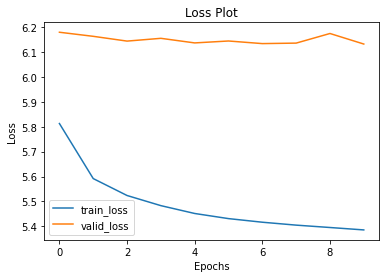

In [29]:
import matplotlib.pyplot as plt
plt.plot(train_loss_plot, label='train_loss')
plt.plot(valid_loss_plot, label='valid_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

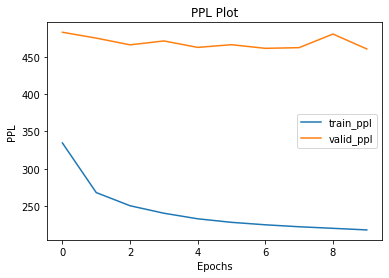

In [30]:
plt.plot(train_ppl_plot, label='train_ppl')
plt.plot(valid_ppl_plot, label='valid_ppl')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('PPL')
plt.title('PPL Plot')
plt.show()

In [28]:
# EU

  0%|          | 0/12745 [00:00<?, ?it/s]


Epoch: 01 | Time: 33m 53s
Train Loss: 5.813 | Train PPL: 334.618
Valid Loss: 6.180 | Valid PPL: 482.890


  0%|          | 0/12745 [00:00<?, ?it/s]


Epoch: 02 | Time: 33m 44s
Train Loss: 5.592 | Train PPL: 268.199
Valid Loss: 6.163 | Valid PPL: 475.042


  0%|          | 0/12745 [00:00<?, ?it/s]


Epoch: 03 | Time: 34m 5s
Train Loss: 5.524 | Train PPL: 250.569
Valid Loss: 6.144 | Valid PPL: 466.008


  0%|          | 0/12745 [00:00<?, ?it/s]


Epoch: 04 | Time: 33m 51s
Train Loss: 5.483 | Train PPL: 240.569
Valid Loss: 6.155 | Valid PPL: 471.242


  0%|          | 0/12745 [00:00<?, ?it/s]


Epoch: 05 | Time: 34m 1s
Train Loss: 5.451 | Train PPL: 233.105
Valid Loss: 6.137 | Valid PPL: 462.618


  0%|          | 0/12745 [00:00<?, ?it/s]


Epoch: 06 | Time: 34m 6s
Train Loss: 5.431 | Train PPL: 228.351
Valid Loss: 6.145 | Valid PPL: 466.205


  0%|          | 1/12745 [00:00<38:20,  5.54it/s]


Epoch: 07 | Time: 34m 16s
Train Loss: 5.416 | Train PPL: 225.064
Valid Loss: 6.134 | Valid PPL: 461.349


  0%|          | 1/12745 [00:00<40:11,  5.28it/s]


Epoch: 08 | Time: 34m 9s
Train Loss: 5.405 | Train PPL: 222.444
Valid Loss: 6.136 | Valid PPL: 462.255


  0%|          | 0/12745 [00:00<?, ?it/s]


Epoch: 09 | Time: 34m 6s
Train Loss: 5.395 | Train PPL: 220.333
Valid Loss: 6.175 | Valid PPL: 480.471


100%|██████████| 10/10 [5:40:26<00:00, 2042.64s/it]


Epoch: 10 | Time: 34m 8s
Train Loss: 5.385 | Train PPL: 218.209
Valid Loss: 6.132 | Valid PPL: 460.537


## Test

In [31]:
#Load model
model.load_state_dict(torch.load('./model/eu/model.pt', map_location=device))

tokenizer = get_tokenizer('./model/eu/')

In [32]:
test_loss = valid(model, test_dataloader, criterion)
print(f'\nTest Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f}')

100%|██████████| 1594/1594 [01:48<00:00, 14.74it/s]


Test Loss: 6.132 | Test PPL: 460.353


## Inference

In [33]:
import torch
import random
from argparse import ArgumentParser

def decode(logits, decoding_strategy='max', k=3, temp=0.4):
    tokenizer.decode(logits.topk(10)[1][0].numpy())
    if decoding_strategy=='top1':
        target = logits.max(1)[1]
    elif decoding_strategy=='topk':
        target = logits.topk(k)[1][0][random.randint(0, k-1)].unsqueeze(-1)
    else:
        target = torch.multinomial(logits.squeeze().div(temp).exp().cpu(), 1)
    return target

def evaluate(sentence):
    with torch.no_grad():
        target = torch.Tensor([tokenizer.token_to_id('<s>')]).long()
        output_sentence = []
        encoder_outputs, hidden = model.encoder(torch.Tensor(tokenizer.encode(sentence).ids).long().unsqueeze(-1))
        # attentions = torch.zeros(MAX_LENGTH, 1, len(tokenizer.encode(sentence).ids)).to(device)
        for t in range(MAX_LENGTH):
            # first input to the decoder is the <sos> token
            output, hidden, attention = model.decoder(target, hidden, encoder_outputs)
            # attentions[i] = attention
            target = decode(output, decoding_strategy)
            if target.numpy() == tokenizer.token_to_id('</s>'):
                return tokenizer.decode(output_sentence)
            else:
                output_sentence.append(target.numpy()[0])
    return tokenizer.decode(output_sentence)

In [34]:
#Load model
device = 'cpu'
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
attn = Attention(ENC_HID_DIM, DEC_HID_DIM, ATTN_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
model = Seq2Seq(enc, dec, device).to(device)
model.load_state_dict(torch.load('./model/eu/model.pt', map_location=device))

tokenizer = get_tokenizer('./model/eu/')

In [ ]:
MAX_LENGTH = 30

#Print welcome message
print('-------------------------------')
print('Welcome to the Chit Chat system')
print("Write 'Bye' to end the system.")
print('-------------------------------')

#Main system loop
user = input('-')
model.eval()
# choices=['top1', 'topk', 'multinomial']
decoding_strategy = "topkZer moduz zaude?Zer moduz zaude?Zer moduz zaude?"

while user != 'Bye' and user != 'Agur':
    sentence = evaluate(user)
    print('+' + sentence.capitalize())
    user = input('-')
    
sentence = evaluate(user)
print('+' + sentence.capitalize())